## __SENTIMENT ANALYSIS IMPLEMENTATION__<hr>

### Import Libraries<hr>
We will use *pandas* and *numpy* for data manipulation, *nltk* for NLP, *matplotlib*, *seaborn*, and *plotly* for data visualization, *sklearn* (Multinomial Naive Bayes) and *keras* (LSTM) for training the model.

In [117]:
import pandas as pd
import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import stopwordsiso as stopwords
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
import ipynb.fs.defs.preprocessing as prep
py.init_notebook_mode(connected=True)
%matplotlib inline

### Setting the Random Seed<hr>
This is to make the output of the models more consistent with the given inputs. Note that since the models are affected by random seeds, we can set the seeds to a constant number (not specifically the same value for all random seeds).

In [118]:
# import os
# import random

# seed = 3000
# os.environ['PYTHONHASHSEED']=str(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# random.seed(seed)

### Load the dataset<hr>
We note that we have 500 entries for twitter (tweets) and facebook (posts and commments) + additional data [random.csv].

>>> (since insufficient yung una para makagreater than 0.75 sa unang dataset na twitter.csv + facebook.csv)

In [119]:
twitter = pd.read_csv('../data/twitter.csv', usecols=[3,4])
facebook = pd.read_csv('../data/facebook.csv', usecols=[3,4])
rand = pd.read_csv('../data/random.csv', usecols=[3,4])
df = pd.concat([twitter, facebook, rand])
df = shuffle(df)
df.head()

,Clean_Translated,Tag
82,"You are so proud to laugh at us, watch the vid...",1
652,Just for you to see your brain you will teach ...,1
171,Eertt Ulol,1
16,Ahs thirst mechanism you say you tasted marvin...,1
331,Do you love to eat seafood in the malls today ...,0


### Data Analysis - Statistics
In the next 2 cells, we examine the shape of our dataset and check if there are some missing values.

>>>(Since minsan may mga cells na puro emojis, puntuation, links, mentions nung na pull) or (baka kasi hindi ma read ng pandas).

In [120]:
print(twitter.shape)
print(facebook.shape)
print(rand.shape)
print(df.shape)

(817, 2)
(501, 2)
(1010, 2)
(2328, 2)


we check for missing values using __isna()__:

>>>Check lang if may null sa kahit anong value sa isang row

In [121]:
# No missing values
twitter[twitter.isna().any(axis=1)]
facebook[facebook.isna().any(axis=1)]
rand[rand.isna().any(axis=1)]
df[df.isna().any(axis=1)]

,Clean_Translated,Tag


### Statistic<hr>
The data sets contains $817$ entries for twitter (tweets), $501$ entries for facebook (posts and comments), and $1010$ entries for additional test data retrieved using the twitter API.

For every sentence/text in the data set, the lengths of these are taken. `lens` is the length of all sentences (by character number) in the dataset. Using this, we can get the __mean value__, __standard deviation__, __minimum__, and __maximum__ of these lengths as shown below:

In [122]:
lens = df['Clean_Translated'].str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

53.29853951890034 43.69666072582707 1 277


Distribution of tweets and post length:

Using the `plotly` module, a histogram is built using `graph_objs.Histogram` to store the data (`lens`) and `graph_objs.Layout` to form the layout of the graph. The figure is then created and rendered using `graph.Figure` and `offline.iplot`. The data shows that most sentences are around 10-39 characters long.

In [123]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=10), marker=dict(color='#8c42f4'))]
layout = go.Layout(
                  title='Length of tweets and post distribution',                  
                  xaxis=dict(title='Length'),
                  yaxis=dict(title='Count'),
                  bargap=0.1)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='length histogram')

Correlate length and sentiment marks:

The data is then checked for correlation between the length of these sentences/text with the sentiment tagged together with the data. The figure below is a scatter plot (using the `plotly` module) where the $x$ values are the length of the text and the $y$ values are the sentiments. The lengths are mostly clumped within the $0-100$ range.

In [124]:
df['Text_Length'] = df['Clean_Translated'].apply(lambda x: len(x))
data = df.sort_values(by='Text_Length')
plot = go.Scatter(x = data['Text_Length'], y = data['Tag'], mode='markers')
lyt = go.Layout(title="Length vs. Sentiment Label", xaxis=dict(title='Review Length'),yaxis=dict(title='Label'))
fig = go.Figure(data=[plot], layout=lyt)
py.iplot(fig)

Pearson correlation:

The Pearson correlation is a statistical tool used to check for statistical relationship, or association, between two continuous variables. In this case, the variables that are to be compared are the tags and the text length. Notice from the figure (*heatmap*) below that the correlation between the tag and length of the is negligible with the value of $0.1$.

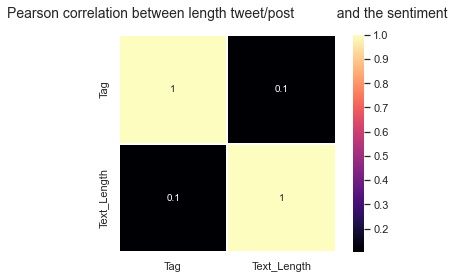

In [125]:
colormap = plt.cm.magma
plt.title('Pearson correlation between length tweet/post\
           and the sentiment', y=1.05, size=14)
sns.heatmap(data.drop(['Clean_Translated'], axis=1).astype(float).corr(),
            linewidths=0.01,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)
plt.show()

#### Commonly seen words in one tag:

The commonly seen words in a tag (sentiment) are given in the word cloud below for visualization purposes. We note that `df_neg` is the splice of the data set where all tags are 1 (negative) and `df_pos` is the splice of the data set where all tags are 0 (positive).

In [126]:
df_neg = df[ df['Tag'] == 1]
df_neg = df_neg['Clean_Translated']
df_pos = df[ df['Tag'] == 0]
df_pos = df_pos['Clean_Translated']

>Commonly seen in "__Negative__" sentences

Using the `wordcloud` module, the common words or phrases that are most likely seen to have negative connotations are shown in the figure below:

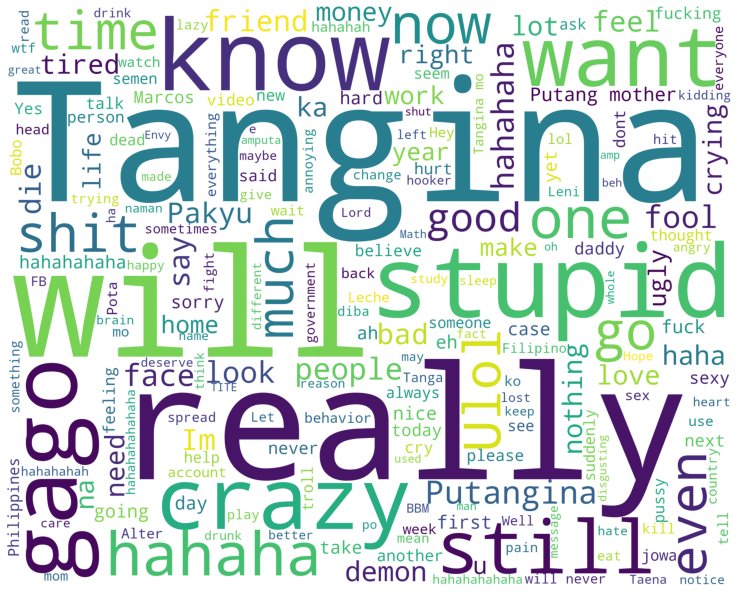

In [127]:
wordcloud1 = WordCloud(stopwords=STOPWORDS, # or stopwords.stopwords("tl") for tagalog
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

>Commonly seen in "__Positive__" sentences

Using the `wordcloud` module, the common words or phrases that are most likely seen to have positive connotations are shown in the figure below:

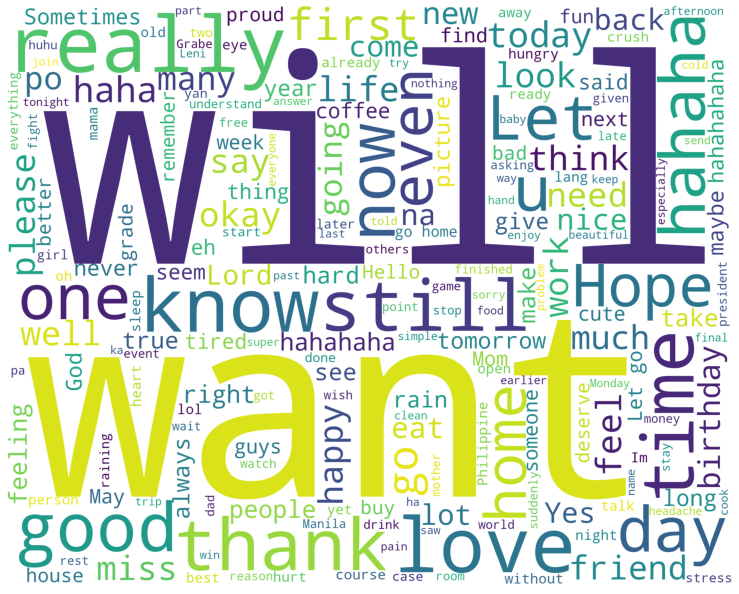

In [128]:
wordcloud2 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))
plt.figure(2,figsize=(13, 13))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

Do note that the `STOPWORDS` from the `wordcloud` module contains stopwords for only english words. Thus, the `stopwordsiso` was also added.

#### Distribution of Sentiments:
We check the distribution of sentiments all throughout the data

>>>distribution lang ng sentiment (count kung ilang sentences yung may anong type ng sentiment)

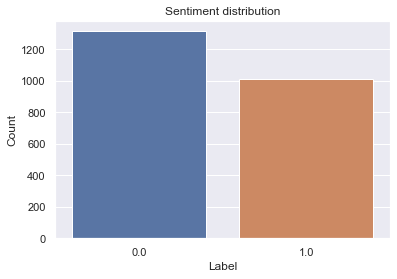

In [129]:
sns.set(style="darkgrid")
b = sns.countplot(x='Tag',
                  data = df.drop(['Clean_Translated'], axis=1).astype(float))
b.axes.set_title('Sentiment distribution')
b.set_xlabel("Label")
b.set_ylabel("Count")
plt.show()

### Text Preprocessing<hr>
Cleaning the text to remove punctuations, transform to lower case, remove emojis, remove hashtags, remove tags, and remove links:

In [130]:
df['Clean_Translated'] = df['Clean_Translated'].apply(prep.simplify_text)
df.head()

,Clean_Translated,Tag,Text_Length
82,you are so proud to laugh at us watch the vide...,1,74
652,just for you to see your brain you will teach ...,1,96
171,eertt ulol,1,10
16,ahs thirst mechanism you say you tasted marvin...,1,160
331,do you love to eat seafood in the malls today ...,0,89


Split for training and testing:

>>>9:1 splitting, yung size naka print sa baba. pa note na magandang 90% yung sa training since more training data mas accurate yung magiging fit.

In [131]:
text = df['Clean_Translated']
tag = df['Tag']
text_train, text_test, tag_train, tag_test = train_test_split(text, tag, test_size=0.1)
print(text_train.shape,text_test.shape)

(2095,) (233,)


### __Naive Bayes__ - Training the Model<hr>
We use parameter $\text{min}_{\text{df}} = 2$ to filter out words that occur only once in the entire dataset.

>>>(Normalization ng text frequency, napagaralan natin dati sa cs 150? pero di included mga words na size 2)

In [132]:
vectorizer = TfidfVectorizer(min_df=2) # term frequency-inverse document frequency
train_term = vectorizer.fit_transform(text_train)
test_term = vectorizer.transform(text_test)

Check words that will be used by the models as features:

>>>Bale ito yung mga features, most common

In [133]:
vectorizer.get_feature_names_out()[100:120]

array(['attend', 'attention', 'attitude', 'audience', 'aunt', 'australia',
       'available', 'avoid', 'awake', 'away', 'ay', 'ayan', 'ayoko', 'ba',
       'baby', 'back', 'bad', 'badly', 'badtrip', 'bag'], dtype=object)

We could then train the Naive Bayes Model:

>>>Bale yung model, Multinomial Naive Bayes. Pero try niyo din bernoulliNB baka mas maganda to. yung fitting gamit lang nung training text pati training tags

In [134]:
model = MultinomialNB()
model.fit(train_term, tag_train)
predictions_train = model.predict(train_term)
predictions_test = model.predict(test_term)
print('Train Accuracy:', accuracy_score(tag_train, predictions_train))
print('Test Accuracy:', accuracy_score(tag_test, predictions_test))

Train Accuracy: 0.8653937947494034
Test Accuracy: 0.759656652360515


### Checking for mistakes in the model<hr>

we use a confusion matrix for visualization.

>>>Same nung kay sir, check errors lang through confusion matrix by count

Confusion matrix, without normalization
[[1139   47]
 [ 235  674]]
Confusion matrix, without normalization
[[117  13]
 [ 43  60]]


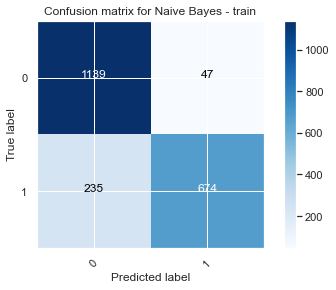

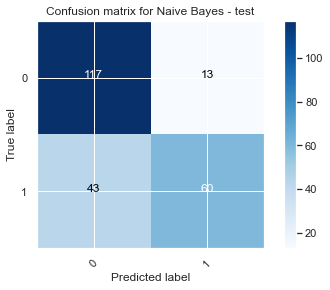

In [135]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix_train = confusion_matrix(tag_train, predictions_train)
cnf_matrix_test = confusion_matrix(tag_test, predictions_test)
plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='Confusion matrix for Naive Bayes - train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for Naive Bayes - test')

### __LSTM__ - Training the Model<hr>
We use Long Short Term Memory Neural Network. We can then use a tokenizer (specifically the one in Keras: note that the other modules may have implementations of tokenizations themselves). We set the maximum feature size to about 3000.

>>>Same sa Naive Bayes, get features. pero this time totokenize natin. yung text dito list ng words (in token form [integers]). Pwede niyo taasan feature count

In [136]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['Clean_Translated'].values)
text = tokenizer.texts_to_sequences(df['Clean_Translated'].values)
text = pad_sequences(text)

We can then build the model using the Keras library. First, we initialize the sequence model. Then, we add word embedding layer, lstm layer with 16 units and the fully connected (dense) layer with 1 (output) neuron with the sigmoid activation function. We use binary_crossentropy loss and Adam optimizer to train the model.

>>>Bale yung key points dito is yung pag add ng layers:<br><br>
embedding layer - layer na embedded yung mga words or kung saang nodes papasok yung words in case na mag ooccur sila sa isang text/sentence<br><br>
LSTM layer - naghahandle ng weights (with backtrack, feedback connections), 16 units yung dimension ng output <br><br>
Dense layer - nag tatake in ng input sa LSTM layer. we will use this layer for output. activation function = sigmoid <br><br>

In [137]:
embed_dim = 64
lstm_out = 16
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=text.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(1,activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 55, 64)            320000    
                                                                 
 lstm_3 (LSTM)               (None, 16)                5184      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 325,201
Trainable params: 325,201
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
tag = df['Tag'].values
text_train, text_test, tag_train, tag_test = train_test_split(text,tag, test_size = 0.1)
print(text_train.shape,tag_train.shape)
print(text_test.shape,tag_test.shape)

(2095, 55) (2095,)
(233, 55) (233,)


We train with a batch size of 16 and train for 6 epoch. The performance of the model is measured on the validation dataset.

In [139]:

batch_size = 16
model.fit(text_train,
          tag_train,
          epochs=6,
          batch_size=batch_size,
          validation_data=(text_test, tag_test),
          callbacks = [EarlyStopping(monitor='val_accuracy',
                       min_delta=0.001,
                       patience=10,
                       verbose=1)]
           )

Epoch 1/6
131/131 [==============================] - 6s 25ms/step - loss: 0.6730 - accuracy: 0.5876 - val_loss: 0.6594 - val_accuracy: 0.5751
Epoch 2/6
131/131 [==============================] - 2s 13ms/step - loss: 0.5125 - accuracy: 0.7609 - val_loss: 0.5449 - val_accuracy: 0.7468
Epoch 3/6
131/131 [==============================] - 2s 13ms/step - loss: 0.2693 - accuracy: 0.8993 - val_loss: 0.5632 - val_accuracy: 0.7425
Epoch 4/6
131/131 [==============================] - 2s 13ms/step - loss: 0.1428 - accuracy: 0.9532 - val_loss: 0.6282 - val_accuracy: 0.7382
Epoch 5/6
131/131 [==============================] - 2s 13ms/step - loss: 0.0962 - accuracy: 0.9723 - val_loss: 0.7267 - val_accuracy: 0.7339
Epoch 6/6
131/131 [==============================] - 2s 13ms/step - loss: 0.0721 - accuracy: 0.9785 - val_loss: 0.7723 - val_accuracy: 0.7468


Check the accuracy of predictions of the LSTM model:

Treshhold of 0.5 (negative if less than 0.5)

In [140]:
predictions_nn_train = model.predict(text_train)
predictions_nn_test = model.predict(text_test)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1
print('Train accuracy:', accuracy_score(tag_train, predictions_nn_train))
print('Test accuracy', accuracy_score(tag_test, predictions_nn_test))

8/8 [==============================] - 0s 6ms/step
Train accuracy: 0.98854415274463
Test accuracy 0.7467811158798283


Check the confusion matrix: confusion matrix

8/8 [==============================] - 0s 9ms/step
Confusion matrix, without normalization
[[1186    8]
 [  16  885]]
Confusion matrix, without normalization
[[93 29]
 [30 81]]


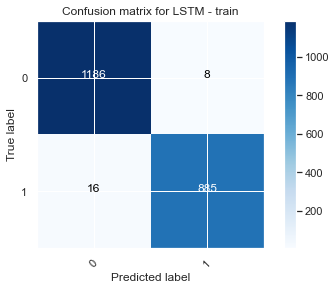

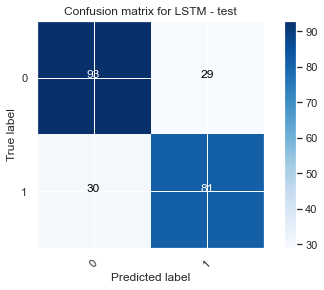

In [141]:
predictions_nn_train = model.predict(text_train)
predictions_nn_test = model.predict(text_test)

cnf_matrix_train = confusion_matrix(tag_train, predictions_nn_train.round())
cnf_matrix_test = confusion_matrix(tag_test, predictions_nn_test.round())

plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='Confusion matrix for LSTM - train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for LSTM - test')

Compute the F1 score:

>>>(same na pala ng pag check sa accuracy_score)

In [142]:
TP = cnf_matrix_test[0][0]
TN = cnf_matrix_test[1][1]
FP = cnf_matrix_test[1][0]
FN = cnf_matrix_test[0][1]
F1 = (TP+TN)/(TP+FP+TN+FN)
print(F1)

0.7467811158798283
